<div style="font-size:13pt;line-height: 1.9;text-decoration:underline;">Φωτεινή Παπαδοπούλου,p3160133</div> 
<div style="text-align:center;font-size:18pt;font-style:italic;line-height: 1.6;">Μηχανική Μάθηση 2019-2020</div>
<div style="text-align:center;font-size:16pt;font-style:italic;line-height: 1.3;">2η Εργασία</div>
<h2 style="text-align:center;"> Μεγιστοποίηση πιθανοφάνειας μίξης Gaussian κατανομών </h2>



In [119]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
from PIL import _imaging

Η εικόνα που θα εισάγουμε ως input είναι ένας πίνακας που το κάθε στοιχείο είναι ένα pixel

(690, 550, 3)

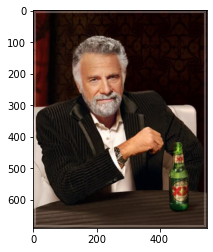

In [120]:
image=img.imread('im.jpg')
plt.imshow(image)
array=np.array(image)
array.shape

Αλλάζουμε τις διαστάσεις του πίνακα σε 690*550,3

In [121]:
new_img = array.reshape((array.shape[0]*array.shape[1]), array.shape[2])
new_img=new_img/255
new_img


array([[0.21176471, 0.        , 0.        ],
       [0.22352941, 0.01176471, 0.01176471],
       [0.28627451, 0.0745098 , 0.0745098 ],
       ...,
       [0.18431373, 0.11764706, 0.08627451],
       [0.18431373, 0.11764706, 0.08627451],
       [0.18431373, 0.11764706, 0.08627451]])

### Αρχικοποίηση των παραμέτρων : σ<sub>k</sub><sup>2</sup>,π<sub>k</sub>,μ<sub>k</sub>

In [122]:
def initialize_mean_cov_pi(X,k):
    N = X.shape[0]
    D = X.shape[1]
    mean = np.zeros((k,D))
    for k_ in range(k):
        for d in range(D):
            mean[k_][d] = np.random.uniform(np.min(X),np.max(X))

    print ("Dimensions mean:",mean.shape)
    print(mean)

    cov_2 = np.zeros(k)
    for k_ in range(k):
        sum1 = 0
        for n in range(N):
            for d in range(D):
                sum1 += np.square(X[n][d] - mean[k_][d])
        cov_2[k_] = sum1 / N

    print("Dimensions cov_2:", cov_2.shape)
    print(cov_2)
    
    a = []
    pi = []
    for i in range(k):
        a.append(np.random.uniform(np.min(X), np.max(X)))
    sum_a = sum(a)
    for x in range(k):
        pi.append(a[x] / sum_a)
    pi = np.array(pi)
    print("Dimensions pi:", pi.shape)
    print(pi)
    return mean ,cov_2, pi

In [123]:
K=4
mean , cov_2 , pi = initialize_mean_cov_pi(new_img,K)
X=new_img

Dimensions mean: (4, 3)
[[0.92944071 0.06730683 0.51521936]
 [0.61571892 0.24983963 0.62076088]
 [0.65390749 0.05646901 0.32841955]
 [0.14448631 0.74398045 0.40914857]]
Dimensions cov_2: (4,)
[0.77837791 0.5311186  0.38308399 0.56656677]
Dimensions pi: (4,)
[0.45015392 0.13455827 0.3673214  0.04796641]


In [124]:
def EM(X,mean,cov_2,pi):

    N, D = X.shape
    K = mean.shape[0]
    Jold = np.inf
    maxIters = 100#number of iterations
    tol = 1e-6#tolerance of convergence
    costs = []
    
    for it in range(maxIters): 
        J = 0#total cost
        print("iteration: ",it)

        # Step 1 -- Calculate a priori possibilities
        gamma = np.zeros((N,K))
        gamma = e_step(X,N,K,mean,cov_2,pi)
        # Step 2 -- Update gaussian parameters
        print("Update Gaussian parameters")
        pi, mean ,cov_2 = m_step(N,D,K,gamma,mean,cov_2,pi)
        
        # Calculate log-likelihood
        print("Calculate log-likelihood")
        J = calculate_log_likelihood(N,D,K,mean,cov_2,pi)
        # Step 3 -- Check for convergence
        costs.append(J)
        print("Iteration #{}, Cost function value: {}".format(it, J))
        if np.abs(J - Jold) < tol:
            break
        Jold = J
    np.save("costs_k_" + str(K),costs)
    return X, mean, cov_2 , pi ,gamma

In [125]:
def Normal(X,n,k,mean,cov_2,pi):
    D=X.shape[1]
    c=1
    try:
        for d in range(D):
            a=1/(np.sqrt(2*np.pi*cov_2[k]))
            e=np.square(X[n][d]-mean[k][d])
            b=a*np.exp((-1/(2*cov_2[k]))*e)
            c=c*b
    except IndexError:
        print("Error with d:",d," n: ",n," k: ",k,"X.shape:", X.shape, "mean.shape ",mean.shape)
    return c
    

In [126]:
def gamma_fun(X,N,K,mean,cov_2,pi):
    gamma = np.zeros((N,K))
    D = mean.shape[1]
    print("Calculate a priori possibilities")
    for k in range(K):
        for n in range(N):            
            a=pi[k]*Normal(X,n,k,mean,cov_2,pi)
            b=sum(pi[j]*Normal(X,n,j,mean,cov_2,pi) for j in range(K))
           
            gamma[n][k]=a/b
    return gamma 

In [127]:
def plot_costs(costs,K):
    x = range(1, len(costs)+1)
    y = costs
    plt.plot(x, y)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("K = "+ str(K))
    plt.show()

 ### Ε-step
 Υπολογισμός του γ(k) ( πιθανότητας δεδομένου ότι ανήκει στην κατηγορια k)
 

In [128]:
def e_step(X,N,K,mean,cov_2,pi):
    return gamma_fun(X,N,K,mean,cov_2,pi)

### M-step 
Ανανέωση των παραμέτρων των gaussian κατανομών

In [129]:
def update_pi(N,k,gamma,mean,cov_2,pi):
    sum1=0
    for n in range(N):
        sum1+=gamma[n][k]
    pi[k]=sum1/N
    return pi

In [130]:
def update_mean(N,D,k,gamma,mean,cov_2,pi):
    sum1=0
    sum2=0
    for d in range(D):
        sum1=sum(gamma[n][k]*X[n][d] for n in range(N))
        sum2=sum(gamma[n][k] for n in range(N))
        mean[k][d]=sum1/(D*sum2)
    return mean

In [131]:
def update_cov_2(N,D,k,gamma,mean,cov_2,pi,mean_new):
    sum1=0
    sum2=0
    for n in range(N):
        sum2+=gamma[n][k]
        for d in range(D):
            sum1+=gamma[n][k]*np.square(X[n][d]-mean_new[k][d])
    cov_2[k]= sum1/(D*sum2)  
    return cov_2

In [132]:
def m_step(N,D,K,gamma,mean,cov_2,pi):
    for k in range(K):
        pi_new=update_pi(N,k,gamma,mean,cov_2,pi)
        mean_new=update_mean(N,D,k,gamma,mean,cov_2,pi)
        cov_2_new=update_cov_2(N,D,k,gamma,mean,cov_2,pi,mean_new)
    return pi_new,mean_new,cov_2_new

In [133]:
def calculate_log_likelihood(N,D,K,mean,cov_2,pi):
    sum1=0
    sum2=0
    for n in range(N):
        sum1=0
        for j in range(K):
            a=Normal(X,n,j,mean,cov_2,pi)
            sum1+=pi[j]*a
        sum2+=np.log(sum1)
    return sum2

In [134]:
meaninit=np.copy(mean)
X,mean,cov_2,pi,gamma=EM(X,mean,cov_2,pi)
np.save("old_file/mean_file_k_" + str(K), mean)
np.save("old_file/gamma_file_k_" + str(K), gamma)
print( "Final k clusters" )
print( mean )
print( "Inital k clusters" )
print( meaninit )

iteration:  0
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #0, Cost function value: -96603.77229371568
iteration:  1
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #1, Cost function value: 314910.3529909074
iteration:  2
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #2, Cost function value: 612799.9608976488
iteration:  3
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #3, Cost function value: 635758.3746013154
iteration:  4
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #4, Cost function value: 643830.5988848171
iteration:  5
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #5, Cost function value: 660831.8258239895
iteration:  6
Calculate a priori possibilities
Update Gaussian parameters
Calculate log

Calculate log-likelihood
Iteration #53, Cost function value: 587458.8774548599
iteration:  54
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #54, Cost function value: 586740.9328552714
iteration:  55
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #55, Cost function value: 586084.7856074321
iteration:  56
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #56, Cost function value: 585486.0456265579
iteration:  57
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #57, Cost function value: 584940.578498009
iteration:  58
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #58, Cost function value: 584444.4772304642
iteration:  59
Calculate a priori possibilities
Update Gaussian parameters
Calculate log-likelihood
Iteration #59, Cost function value: 583994.033936958

<span style="font-size:13pt">Έχοντας αποθηκεύσει τους πίνακες gamma και mean μπορούμε να δούμε την εικόνα η οποία δημιουργήθηκε μετά από τον αλγόριθμο.</span>
 <div style="font-size:10pt">****Λόγω των περιορισμένων υπολογιστικών πόρων και της μικρής υπολογιστικής ισχύος που διέθετα, δεν κατέστει εφικτή η δημιουργία της εικόνας για Κ = 16 , Κ = 32 , Κ = 64. Ο χρόνος που χρειαζόταν για να υπολογιστούν οι πίνακες για τα παραπάνω Κ ήταν αρκετά μεγάλος όπως αντιλαμβάνεστε σε υπολογιστή με μικρή μνήμη.* </div>

In [90]:
def load_image(gamma,mean,new_img):
    rec_img=np.zeros((X.shape[0],X.shape[1]))
    for n in range(X.shape[0]):
        rec_img[n] = mean[gamma[n].argmax()]
    plt.imshow(np.reshape(rec_img,(array.shape[0],array.shape[1],array.shape[2])))
    plt.show()

    from numpy import linalg as LA
    N=rec_img.shape[0]
    error=np.square(LA.norm(new_img-rec_img))/N
    print("Error:"+str(error))


Για __Κ=1__

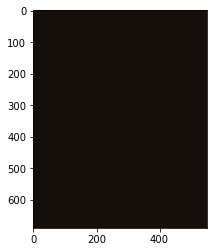

Error:0.22837073457205884


In [91]:
k_=1
gamma1 = np.load("old_file/gamma_file_k_"+str(k_)+".npy")
mean1 = np.load("old_file/mean_file_k_"+str(k_)+".npy")
load_image(gamma1,mean1,new_img)

Για __Κ=2__

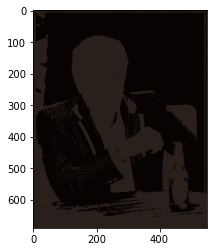

Error:0.17957694035218394


In [92]:
k_=2
gamma2 = np.load("old_file/gamma_file_k_"+str(k_)+".npy")
mean2 = np.load("old_file/mean_file_k_"+str(k_)+".npy")
load_image(gamma2,mean2,new_img)

Για __Κ=4__

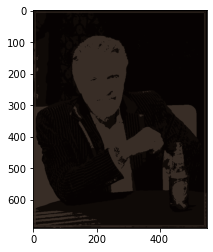

Error:0.15537167646594605


In [141]:
k_=4
gamma4 = np.load("old_file/gamma_file_k_"+str(k_)+".npy")
mean4 = np.load("old_file/mean_file_k_"+str(k_)+".npy")
load_image(gamma4,mean4,new_img)

Για __Κ=8__

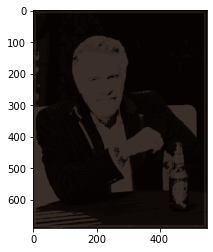

Error:0.1502236014262118


In [97]:
k_=8
gamma8 = np.load("old_file/gamma_file_k_"+str(k_)+".npy")
mean8 = np.load("old_file/mean_file_k_"+str(k_)+".npy")
load_image(gamma8,mean8,new_img)